#### Demonstration of the Structure Seer model capabilities

In [ ]:
!pip install torch
!pip install rdkit
!pip install pubchempy
!pip install networkx[default]
!pip install tqdm
!pip install matplotlib

 - Initiate the model class and load QM-9 pre-trained weights

In [1]:
import torch
import torch.nn.functional as F
from models import StructureSeer
from utils import MolGraph

%matplotlib inline

qm9_model = StructureSeer()
qm9_model.encoder.load_state_dict(
    torch.load(
        "weights/structure_seer/qm9/qm9_structure_seer_encoder.weights",
        map_location="cpu",
    )
)
qm9_model.decoder.load_state_dict(
    torch.load(
        "weights/structure_seer/qm9/qm9_structure_seer_decoder.weights",
        map_location="cpu",
    )
)

<All keys matched successfully>

- Element and shielding constants vectors declaration (input for the model)

In [2]:
# dsgdb9nsd_121697.xyz
elements_vector = torch.tensor([6, 6, 6, 6, 6, 7, 7, 8, 8])
shielding_constants_vector = torch.tensor([ 79.994, 93.406, 179.437, 225.061, 227.187, 55.066, 198.318, -204.424, 344.265])

Pre-processing of input
- Padding
- Normalisation of shielding constants

In [3]:
def preprocess_input(elements_vector, shielding_constants_vector):
    size = elements_vector.size(dim=0)
    pad_size = 54 - size
    # Normalise shielding to (0, 1) range for shielding in (-1000, 1000)
    normalised_shielding = torch.tensor([(x + 1000) / 2000 for x in shielding_constants_vector])
    input_vectors = [ F.pad(elements_vector, (0, pad_size), value=0), F.pad(normalised_shielding, (0, pad_size), value=0)]
    return input_vectors, size

input_vectors, size = preprocess_input(elements_vector, shielding_constants_vector)

Predictions

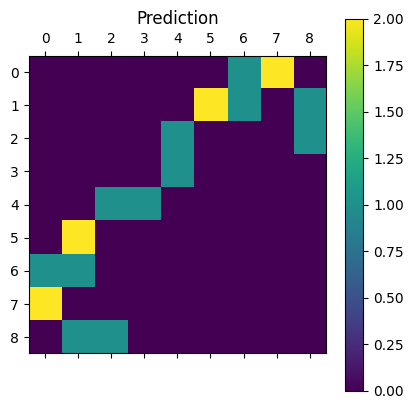

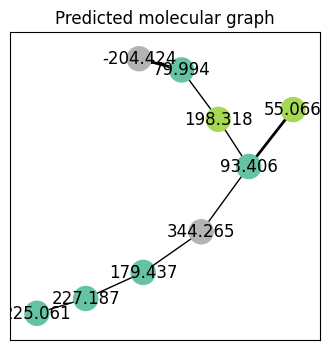

In [4]:
from utils import show_adjacency_matrix
%matplotlib inline

prediction = qm9_model.predict(input_vectors)
show_adjacency_matrix(matrix=prediction, title="Prediction", size=size)
nodes = torch.zeros((size,2))
for i in range(size):
    nodes[i][0] = elements_vector[i]
    nodes[i][1] = shielding_constants_vector[i]
    
prediction_graph = MolGraph.from_adjacency_matrix(nodes=nodes, adjacency_matrix=prediction)
prediction_graph.show(size=4, title="Predicted molecular graph")


- Find and show target adjacency matrix and molecular graph

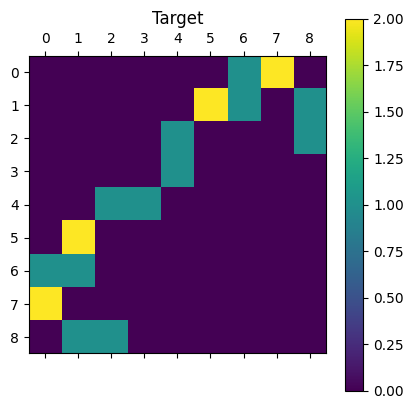

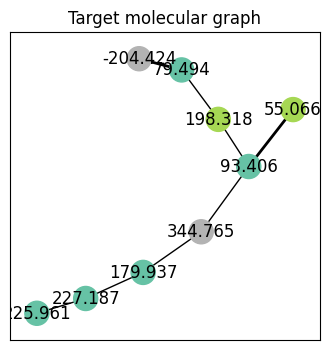

In [5]:
from utils import read_sdf_compounds
compounds = read_sdf_compounds("example_datasets/demo_compounds_qm9.sdf")
for compound in compounds:
    if compound.GetProp("_Name") == "dsgdb9nsd_121697.xyz":
        target_graph = MolGraph.from_mol(compound, shielding=True).sort(shielding=True)[0]
        target_matrix = target_graph.adjacency_matrix()
        show_adjacency_matrix(matrix=target_matrix, title="Target", size=size)
        target_graph.show(size=4, title="Target molecular graph")
        break

The same workflow for the PubChem dataset sample:

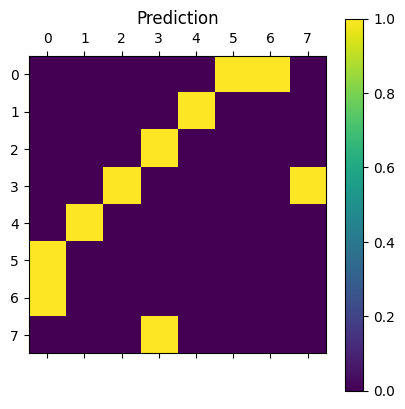

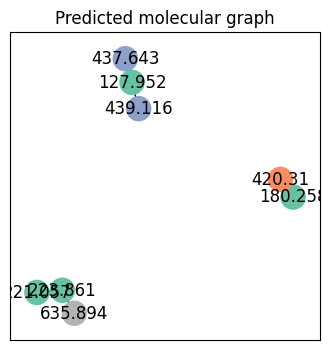

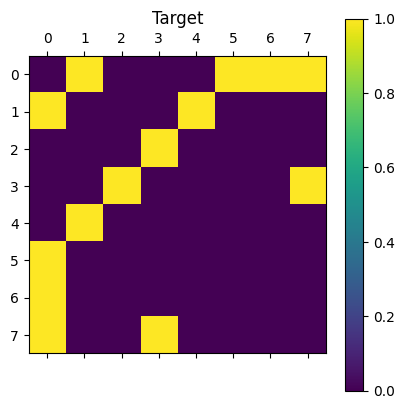

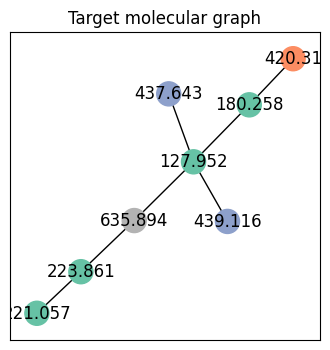

In [6]:
pubchem_model = StructureSeer()
pubchem_model.encoder.load_state_dict(
    torch.load(
        "weights/structure_seer/pubchem/pubchem_structure_seer_encoder.weights",
        map_location="cpu",
    )
)
pubchem_model.decoder.load_state_dict(
    torch.load(
        "weights/structure_seer/pubchem/pubchem_structure_seer_decoder.weights",
        map_location="cpu",
    )
)

# pubchem_cid_86033414
elements_vector = torch.tensor([ 6,  6,  6,  6,  8,  9,  9, 16])
shielding_constants_vector = torch.tensor([127.9520, 180.2580, 221.0570, 223.8610, 420.3100, 437.6430, 439.1160,
        635.8940])
input_vectors, size = preprocess_input(elements_vector, shielding_constants_vector)

prediction = pubchem_model.predict(input_vectors)
show_adjacency_matrix(matrix=prediction, title="Prediction", size=size)
nodes = torch.zeros((size,2))
for i in range(size):
    nodes[i][0] = elements_vector[i]
    nodes[i][1] = shielding_constants_vector[i]
    
prediction_graph = MolGraph.from_adjacency_matrix(nodes=nodes, adjacency_matrix=prediction)
prediction_graph.show(size=4, title="Predicted molecular graph")

compounds = read_sdf_compounds("example_datasets/demo_compounds_pubchem.sdf")
for compound in compounds:
    if compound.GetProp("_Name") == "pubchem_cid_86033414":
        target_graph = MolGraph.from_mol(compound, shielding=True).sort(shielding=True)[0]
        target_matrix = target_graph.adjacency_matrix()
        show_adjacency_matrix(matrix=target_matrix, title="Target", size=size)
        target_graph.show(size=4, title="Target molecular graph")
        break




The model can be used for peak attribution

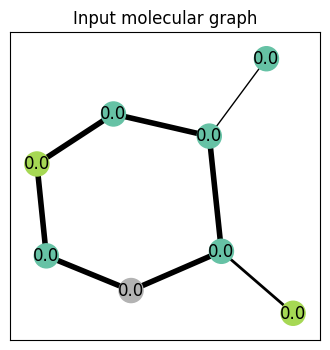

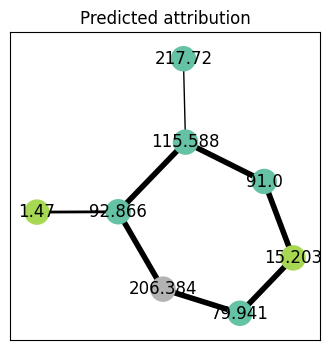

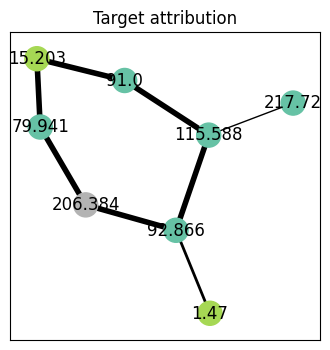

In [7]:
from utils import generate_shielding_permutations, generate_adjacency_matrix_permutations
# dsgdb9nsd_004997.xyz
compounds = read_sdf_compounds("example_datasets/demo_compounds_qm9.sdf")
for compound in compounds:
    if compound.GetProp("_Name") == "dsgdb9nsd_004997.xyz":
        compound_for_attribution = compound
        break
        
graph_for_attribution = MolGraph.from_mol(compound_for_attribution, shielding=False).sort()[0]
matrix = graph_for_attribution.adjacency_matrix()

# Spectra is specified
elements_vector = torch.tensor([6, 6, 6, 6, 6, 7, 7, 8])
shielding_constants_vector = torch.tensor([79.9410,  91.0000,  92.8660, 115.5880, 217.7200,   1.4700,  15.2030, 206.3840])

input_vectors, size = preprocess_input(elements_vector, shielding_constants_vector)
nodes = torch.zeros((size,2))
for i in range(size):
    nodes[i][0] = elements_vector[i]
    nodes[i][1] = shielding_constants_vector[i]

permutations = generate_shielding_permutations(nodes)
perm_count = len(permutations)

input_permutations = generate_adjacency_matrix_permutations(elements_vector, permutations, matrix)
t1 = torch.argmax(input_permutations, dim=-1)

output = qm9_model.predict(input_vectors)
prediction_tensor = torch.stack([output] * perm_count, dim=0)
t2 = torch.argmax(prediction_tensor, dim=-1)

diff = torch.abs(t2 - t1)
s_diff = torch.reshape(diff, (diff.size(dim=0), diff.size(dim=1) * diff.size(dim=2)))
summs = torch.sum(s_diff, dim=-1)
top_idx = torch.argmin(summs)
top_permutation = input_permutations[top_idx]

predicted_attribution = MolGraph.from_adjacency_matrix(nodes=nodes, adjacency_matrix=top_permutation)
target_attribution = MolGraph.from_mol(compound_for_attribution, shielding=True)

graph_for_attribution.show(size=4, title="Input molecular graph")
predicted_attribution.show(size=4, title="Predicted attribution")
target_attribution.show(size=4, title="Target attribution")